In [2]:
from datetime import time
import datetime
import pandas as pd
from pandas import DataFrame
import pdb
from itertools import groupby
import re

In [3]:
filename_entire = 'day_in_the_life.xls'
duration_threshold = 60

In [4]:
def difftime(df):
    # df = pd.read_excel(filename_entire, index=None)
    for index, row in df.iterrows():
        if pd.isnull(row['Time of Departure']) | pd.isnull(row['Time of Arrival']):
            df.loc[index,'Duration'] = 'NULL'
        elif pd.isnull(re.match("[0000]+",str(row['Time of Departure']))) & pd.isnull(re.match("[0000]+",str(row['Time of Arrival']))):
            df.loc[index, 'Duration'] = ((row['Time of Departure']-row['Time of Arrival']).seconds)/60
            # print(df.loc[index, 'Duration'])
        else:
            df.loc[index, 'Duration'] = 'NULL'
    return df
#     DataFrame(df).to_excel(filename_entire, sheet_name='day_in_the_life', index=False, header=True)

In [5]:
def abbreviation(df):
    # df = pd.read_excel(filepath, index=None)
#     pdb.set_trace()
    location_types = []
    locatypes_abb = []
    for index, row in df.iterrows():
        drop = re.sub(u"\\(.*?\\)","",row['Location_Type'])
        strip = drop.strip()
        if strip not in location_types:
            location_types.append(strip)
        abbre = "".join([i[0].upper() for i in strip.split(" ")])
        if strip == "Public Transport":
            abbre = 'PubT'
        if strip == "Private Transport":
            abbre = 'PriT'
        if abbre not in locatypes_abb:
            locatypes_abb.append(abbre)
        df.loc[index, 'Location_Type'] = abbre
    # DataFrame(df).to_excel(filepath, sheet_name='day_in_the_life', index=False, header=True)
    location_types.sort()
    locatypes_abb.sort()
    return df, location_types, locatypes_abb

In [6]:
def move(df):
    # df = pd.read_excel(filepath, index=None)
    for index, row in df.iterrows():
        if row['Location_Type'] in ["PubT","CJ","PriT"]:
            df.loc[index, 'Location_Type'] = "M"
    # DataFrame(df).to_excel(filepath, sheet_name='day_in_the_life', index=False, header=True)
    return df

In [7]:
def drop_continuous_repeat_types(df):
    row_del = []
    for index, row in df.iterrows():
        
        if (index > 0) & (df.iloc[index-1]['Subject'] == df.iloc[index]['Subject']) & (df.iloc[index]['Location_Type'] == df.iloc[index-1]['Location_Type']):
            df.loc[index, 'Duration'] = df.iloc[index-1]['Duration'] + df.iloc[index]['Duration']
            row_del.append(index-1)
    
    df = df.drop(row_del, axis=0)
    row_del_thres = []
    for index, row in df.iterrows():
        if row['Duration'] < 0:
            row_del_thres.append(index)
    df = df.drop(row_del_thres, axis=0)
    return df

In [8]:
def merge_locationType(df):
#     row_del = []
#     for index, row in df.iterrows():
#         if (index > 0) & (df.iloc[index-1]['Subject'] == df.iloc[index]['Subject']) & (df.iloc[index]['Location_Type'] == df.iloc[index-1]['Location_Type']):
#             df.loc[index, 'Duration'] = df.iloc[index-1]['Duration'] + df.iloc[index]['Duration']
#             row_del.append(index-1)
#     pdb.set_trace()
#     df = df.drop(row_del, axis=0)
#     row_del_thres = []
#     for index, row in df.iterrows():
#         if row['Duration'] < duration_threshold:
#             row_del_thres.append(index)
#     df = df.drop(row_del_thres, axis=0)
    df = df.groupby(['Subject', 'Age', 'Gender'])['Location_Type'].apply(ab)
    df = df.reset_index()
#     df_test = df_norepeat.groupby(['Subject', 'Age', 'Gender']).apply(lambda x: pd.Series({
#                                                           'Types_merge'        : ab(x['Location_Type']),
#                                                           'Duration_sum'       : x['Duration'].sum()
#                                                       })
#                                                     )
#     df_test = df_test.reset_index()
    # DataFrame(df).to_excel(filepath, sheet_name='day_in_the_life', index=False, header=True)
    return df

In [9]:
def ab(df):
#     pdb.set_trace()
    locations = df.values
#     locations_dupe = [x[0] for x in groupby(locations)]
    return '-'.join(locations.tolist())

In [10]:
def drop_repeat_types(df):
    df = df.groupby(['Subject', 'Age', 'Gender','Location_Type'])['Duration'].apply(sum)
    df = df.reset_index()
    return df

In [11]:
def append(df):
#     pdb.set_trace()
    values = df.values
    return values.tolist()

In [12]:
# read csv as dataframe
df = pd.read_excel(filename_entire, index=None)

# strip out content in parentheses and get first character to represent the word
df_abb, location_types, location_abb = abbreviation(df)

print(location_abb)
print(location_types)
# make all on the way location type as M
# df_move = move(df_abb)

# drop repea
df_no_conrepeat = drop_continuous_repeat_types(df_abb)
df_norepeat = drop_repeat_types(df_no_conrepeat)
# merge all the location type for one subject
# df_merge = merge_locationType(df_norepeat)


['AAC', 'CJ', 'H', 'O', 'PS', 'PriT', 'PubT', 'R', 'RAH', 'S', 'SAR', 'W']
['Arts and culture', 'Car journey', 'Home', 'Other', 'Private Transport', 'Public Transport', 'Public spaces', 'Refused', 'Retail and hospitality', 'Sport and recreation', 'Study', 'Work']


In [13]:
print(len(df_norepeat))

4354


In [14]:
df_test_dic = df_abb.groupby(['Subject', 'Age', 'Gender']).apply(lambda x: pd.Series({
                                                              'Types_merge'        : ab(x['Location_Type']),
                                                              'Duration_sum'       : append(x['Duration'])
                                                          })
                                                        )
df_test_dic = df_test_dic.reset_index()

In [15]:
df_test = df_norepeat.groupby(['Subject', 'Age', 'Gender']).apply(lambda x: pd.Series({
                                                              'Types_merge'        : ab(x['Location_Type']),
                                                              'Duration_sum'       : append(x['Duration'])
                                                          })
                                                        )
df_test = df_test.reset_index()

In [16]:
import numpy as np

In [17]:
def vectorize(df):
    X_type = []
    X_duration = []
    for index, row in df.iterrows():
        vector_type = [0,0,0,0,0,0,0,0,0,0,0]
        vector_duration = [0,0,0,0,0,0,0,0,0,0,0]
        location_types = df.iloc[index]['Types_merge'].split("-")
        durations = df.iloc[index]['Duration_sum']
#         pdb.set_trace()
#         print(index)
        for i,location_type in enumerate(location_types):
            if location_type == 'AAC':
                vector_type[0] = 1
                vector_duration[0] = durations[i]
            elif location_type == 'CJ':
                vector_type[1] = 1
                vector_duration[1] = durations[i]
            elif location_type == 'H':
                vector_type[2] = 1
                vector_duration[2] = durations[i]
            elif location_type == 'O':
                vector_type[3] = 1
                vector_duration[3] = durations[i]
            elif location_type == 'PS':
                vector_type[4] = 1
                vector_duration[4] = durations[i]
            elif location_type == 'PriT':
                vector_type[5] = 1
                vector_duration[5] = durations[i]
            elif location_type == 'PubT':
                vector_type[6] = 1
                vector_duration[6] = durations[i]
            elif location_type == 'RAH':
                vector_type[7] = 1
                vector_duration[7] = durations[i]
            elif location_type == 'S':
                vector_type[8] = 1
                vector_duration[8] = durations[i]
            elif location_type == 'SAR':
                vector_type[9] = 1
                vector_duration[9] = durations[i]
            elif location_type == 'W':
                vector_type[10] = 1
                vector_duration[10] = durations[i]
        X_type.append(vector_type)
        X_duration.append(vector_duration)
    return X_type,X_duration

In [18]:
X_location_type, X_duration = vectorize(df_test)

In [32]:
np.savetxt('datarepre_01',X_location_type)
np.savetxt('datarepre_duration_norder',X_duration)

In [39]:
# a = np.loadtxt('datarepre_format_01')
# print(a)

In [19]:
from collections import defaultdict
def vectorize_dic(df):
    X_dic_times = []
    X_dic_duration = []
    X_freq = []
    duration_order = []
    text_type = []
    for index, row in df.iterrows():
        vector_type_freq = [0,0,0,0,0,0,0,0,0,0,0]
        dic_times = defaultdict(int)
        dic_duration = defaultdict(int)
        location_types = df.iloc[index]['Types_merge'].split("-")
        durations = df.iloc[index]['Duration_sum']
#         pdb.set_trace()
#         print(index)
        for i,location_type in enumerate(location_types):
            if location_type == 'AAC':
                dic_times['AAC'] += 1
                dic_duration['AAC'] += durations[i]
                vector_type_freq[0] += 1
            elif location_type == 'CJ':
                dic_times['CJ'] += 1
                dic_duration['CJ'] += durations[i]
                vector_type_freq[1] += 1
            elif location_type == 'H':
                dic_times['H'] += 1
                dic_duration['H'] += durations[i]
                vector_type_freq[2] += 1
            elif location_type == 'O':
                dic_times['O'] += 1
                dic_duration['O'] += durations[i]
                vector_type_freq[3] += 1
            elif location_type == 'PS':
                dic_times['PS'] += 1
                dic_duration['PS'] += durations[i]
                vector_type_freq[4] += 1
            elif location_type == 'PriT':
                dic_times['PriT'] += 1
                dic_duration['PriT'] += durations[i]
                vector_type_freq[5] += 1
            elif location_type == 'PubT':
                dic_times['PubT'] += 1
                dic_duration['PubT'] += durations[i]
                vector_type_freq[6] += 1
            elif location_type == 'RAH':
                dic_times['RAH'] += 1
                dic_duration['RAH'] += durations[i]
                vector_type_freq[7] += 1
            elif location_type == 'S':
                dic_times['S'] += 1
                dic_duration['S'] += durations[i]
                vector_type_freq[8] += 1
            elif location_type == 'SAR':
                dic_times['SAR'] += 1
                dic_duration['SAR'] += durations[i]
                vector_type_freq[9] += 1
            elif location_type == 'W':
                dic_times['W'] += 1
                dic_duration['W'] += durations[i]
                vector_type_freq[10] += 1
        X_freq.append(vector_type_freq)    
        X_dic_times.append(dic_times)
        X_dic_duration.append(dic_duration)
        duration_order.append(durations)
        text_type.append(location_types)
    return X_dic_times,X_dic_duration, X_freq, duration_order, text_type

In [20]:
X_location_type_dic, X_duration_dic, X_freq, duration_order, text_type = vectorize_dic(df_test_dic)

In [ ]:
np.savetxt('datarepre_frequency',X_freq)
np.savetxt('datarepre_duration_order',duration_order)
np.savetxt('datarepre_text_type',text_type)

In [138]:
print(X_location_type)

[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0], [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0], [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1], [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1], [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 1, 0, 0, 

In [148]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
matrix_freq = vec.fit_transform(X_location_type_dic)
# print(vec.fit_transform(X_location_type_dic))

In [57]:
print(vec.get_feature_names())

['AAC', 'CJ', 'H', 'O', 'PS', 'PT', 'RAH', 'S', 'SAR', 'W']


In [58]:
############################ Unsupervised algorithms ###############################

In [351]:
from sklearn.cluster import KMeans
X = np.array(X_duration)
kmeans_model = KMeans(n_clusters=4, random_state=0).fit(X)
print(kmeans_model.labels_)
print(kmeans_model.cluster_centers_)
print(np.round(kmeans_model.cluster_centers_, 0))

[1 3 1 ... 1 1 3]
[[  1.21317829  26.63565891 344.57364341  16.25581395   6.5620155
   27.70155039  11.69767442  19.55813953   6.10465116  14.28294574
  512.82945736]
 [  3.09682805   6.07011686 865.92654424  16.74791319   8.08347245
   14.74457429   1.44407346  30.67111853   2.59933222   8.5375626
    6.03672788]
 [  4.3220339   17.79661017 298.24576271 351.33898305  45.56779661
   85.28813559  32.55084746  33.62711864  23.63559322  15.27966102
   18.01694915]
 [ 24.78915663  19.58433735 546.71385542  62.89457831  24.36746988
   48.37951807  10.73795181 116.20783133  38.59638554  40.44277108
   15.34036145]]
[[  1.  27. 345.  16.   7.  28.  12.  20.   6.  14. 513.]
 [  3.   6. 866.  17.   8.  15.   1.  31.   3.   9.   6.]
 [  4.  18. 298. 351.  46.  85.  33.  34.  24.  15.  18.]
 [ 25.  20. 547.  63.  24.  48.  11. 116.  39.  40.  15.]]


In [439]:
import numpy as np
import matplotlib.pyplot as plt
def ClusterIndicesNumpy(clustNum, labels_array):
    return np.where(labels_array == clustNum)[0]
def virtualizeClusterPie(averages,len_cluster):
    x = ['Arts and culture', 'Car journey', 'Home', 'Other', 'Private Transport', 'Public Transport', 
         'Public spaces', 'Retail and hospitality', 'Sport and recreation', 'Study', 'Work']
    colors = ['w' for i in range(11)]
    proportion = [i/sum(len_cluster) for i in len_cluster]
#     plts = []
#     fig, ys = plt.subplots(2, 2, figsize=(40,10))
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()
    for i,average in enumerate(averages):
        y = average
        sizes = np.array(average)
        def absolute_value(val):
            a  = np.round(val/100.*sizes.sum(), 0)
            return a
#         plts.append(ys[i].pie(y,labels=x,autopct=absolute_value))
        ax = plt.subplot(2, 2, i + 1)
#         plt.subplots_adjust(wspace =0.1, hspace =0)
        plt.axis("off")
        ax.set_title(str(len_cluster[i]) + " subjects" + '(' + str(np.round(proportion[i],4)* 100) + '%)')
        plt.pie(y,labels=x,autopct=absolute_value,textprops={'fontsize': 12, 'color': 'black'},explode=(0.2,0.4,0,0,0,0,0,0,0.2,0,0))
    plt.legend(loc='right', ncol = 3,bbox_to_anchor=(0.5,-0.1),prop={'size':20})   
#     fig.legend(plts,     # The line objects
#                labels=x,   # The labels for each line
#                loc="lower center",   # Position of legend
#                borderaxespad=0.1,    # Small spacing around legend box
#                title="Legend Title",  # Title for the legend
#                ncol = 3              #columns
#                )
    plt.subplots_adjust(right=0.85)
    plt.savefig("result.png")
    plt.show()

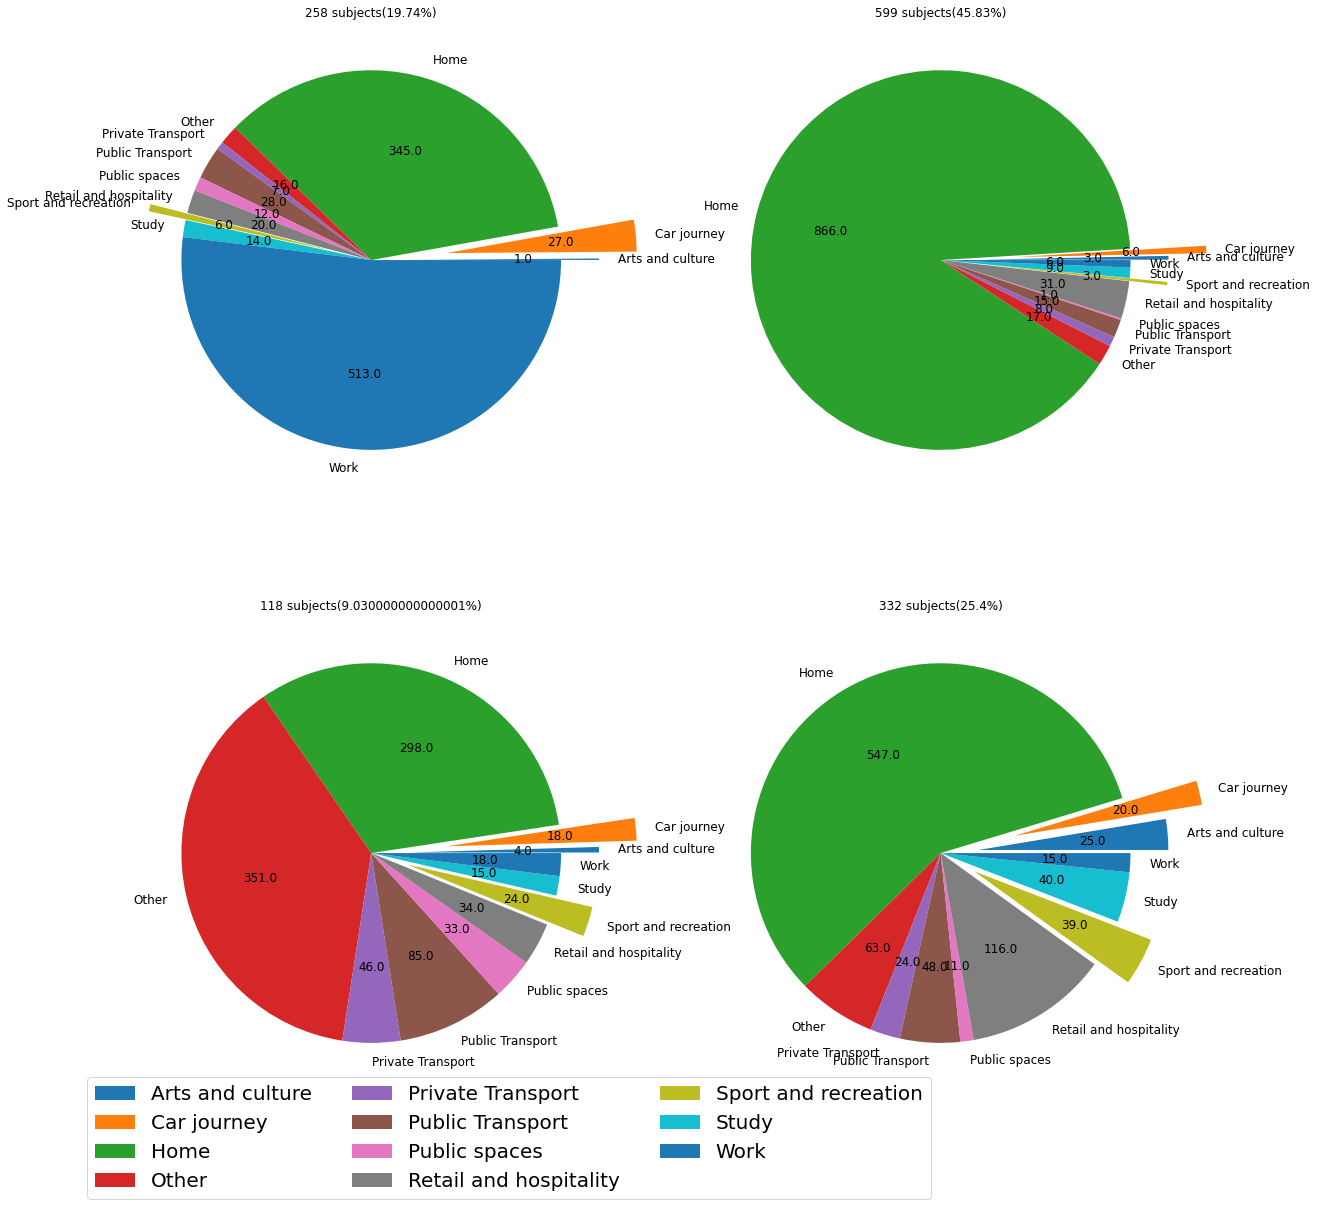

In [440]:
clusters = [X[ClusterIndicesNumpy(i,kmeans_model.labels_)] for i in range(4)]
# cluster0 = X[ClusterIndicesNumpy(0,kmeans_model.labels_)]
len_cluster = [len(i) for i in clusters]
average = [np.mean(i, axis=0) for i in clusters]
virtualizeClusterPie(average, len_cluster)

In [156]:
def virtualizeClusterPlo(clusters):
    x = ['Arts and culture', 'Car journey', 'Home', 'Other', 'Private Transport', 'Public Transport', 
         'Public spaces', 'Retail and hospitality', 'Sport and recreation', 'Study', 'Work']
    plt.figure(figsize=(20, 10))
    for i, cluster in enumerate(clusters):
        plt.plot(x, cluster, label='cluster'+str(i))
    plt.legend()
    plt.savefig("resultplot.png")
    plt.show()

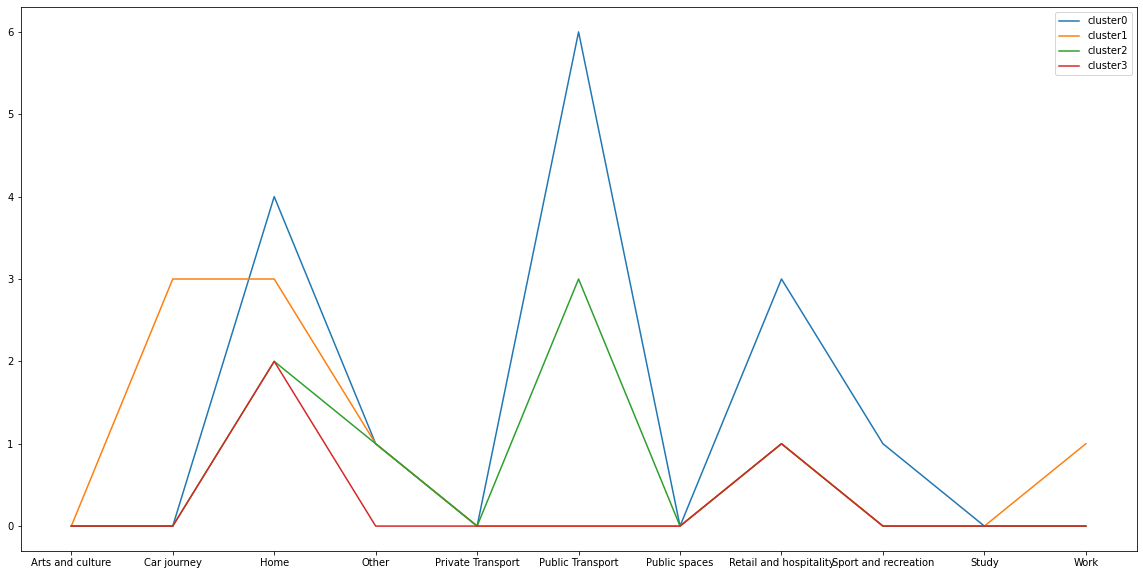

In [157]:
clusters = []
for i in range(4):
    clusters.append(np.round(np.mean(X[ClusterIndicesNumpy(i,kmeans_model.labels_)], axis=0),0))
virtualizeClusterPlo(clusters)

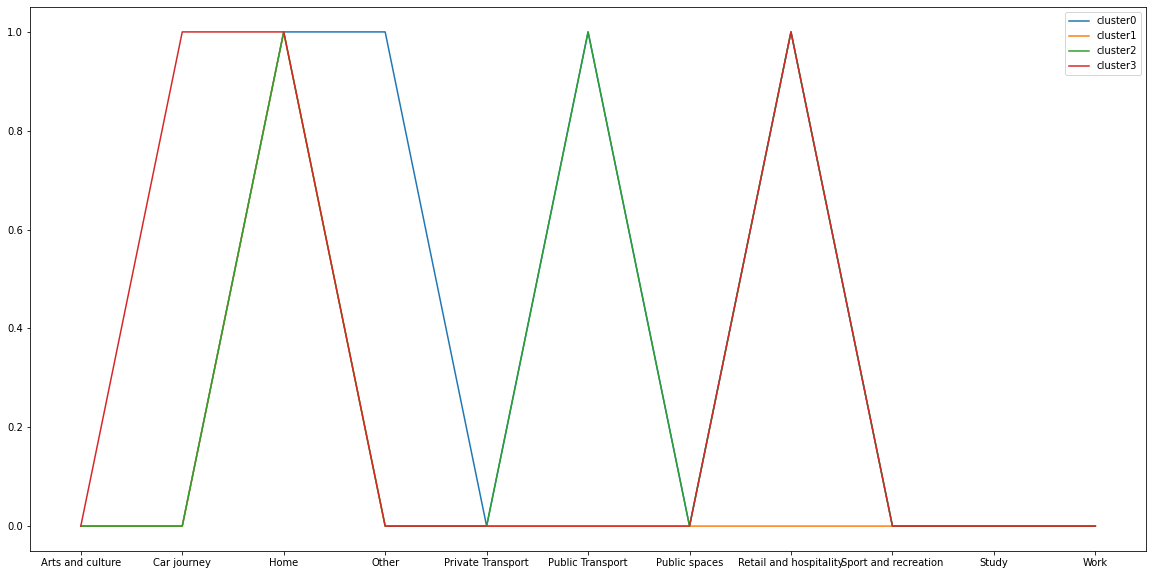

In [142]:
virtualizeClusterPlo(np.round(kmeans_model.cluster_centers_, 0))

In [1]:
####### evaluation ###########
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
labels = kmeans_model.labels_
sc_kmeans = metrics.silhouette_score(X, labels, metric='euclidean')
chi_kmeans = metrics.calinski_harabasz_score(X, labels)
dbi_kmeans = davies_bouldin_score(X, labels)
print(sc_kmeans)
print(chi_kmeans)
print(dbi_kmeans)

NameError: name 'kmeans_model' is not defined

In [289]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1307)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_

sc_meanshift = metrics.silhouette_score(X, labels, metric='euclidean')
chi_meanshift = metrics.calinski_harabasz_score(X, labels)
dbi_meanshift = davies_bouldin_score(X, labels)
print(sc_meanshift)
print(chi_meanshift)
print(dbi_meanshift)

cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

0.4175069467042132
183.44140530081063
1.0344816213380597
number of estimated clusters : 18


In [336]:
from sklearn.cluster import SpectralClustering
sp_clustering = SpectralClustering(n_clusters=3,assign_labels="discretize",random_state=0).fit(X)
labels = sp_clustering.labels_

sc_sp = metrics.silhouette_score(X, labels, metric='euclidean')
chi_sp = metrics.calinski_harabasz_score(X, labels)
dbi_sp = davies_bouldin_score(X, labels)
print(sc_sp)
print(chi_sp)
print(dbi_sp)

0.4990857501012008
81.37281758628241
0.8950244134275652


In [100]:
from sklearn.cluster import AgglomerativeClustering
ac_clustering = AgglomerativeClustering().fit(X)
labels = ac_clustering.labels_
sc_ac = metrics.silhouette_score(X, labels, metric='euclidean')
chi_ac = metrics.calinski_harabasz_score(X, labels)
dbi_ac = davies_bouldin_score(X, labels)
print(sc_ac)
print(chi_ac)
print(dbi_ac)

0.39849308349043455
309.9415344236056
1.2489161717902881


In [101]:
from sklearn.cluster import DBSCAN
dbscan_clustering = DBSCAN(eps=1, min_samples=2).fit(X)
labels = dbscan_clustering.labels_
sc_dbscan = metrics.silhouette_score(X, labels, metric='euclidean')
chi_dbscan = metrics.calinski_harabasz_score(X, labels)
dbi_dbscan = davies_bouldin_score(X, labels)
print(sc_dbscan)
print(chi_dbscan)
print(dbi_dbscan)

-0.2435249479349085
8.629192822449662
1.4896727997486214


In [102]:
from sklearn.cluster import OPTICS
optics_clustering = OPTICS(min_samples=2).fit(X)
labels = optics_clustering.labels_
sc_optics = metrics.silhouette_score(X, labels, metric='euclidean')
chi_optics = metrics.calinski_harabasz_score(X, labels)
dbi_optics = davies_bouldin_score(X, labels)
print(sc_optics)
print(chi_optics)
print(dbi_optics)

0.3261992550984437
6.868096867639848
1.3344020216073165


/usr/local/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


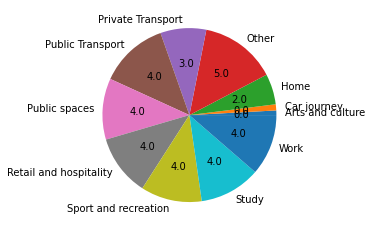

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#X轴，Y轴数据
x = ['Arts and culture', 'Car journey', 'Home', 'Other', 'Private Transport', 'Public Transport', 
     'Public spaces', 'Retail and hospitality', 'Sport and recreation', 'Study', 'Work']
y = [0.3,0.4,2,5,3,4.5,4,4,4,4,4]
sizes = np.array([0.3,0.4,2,5,3,4.5,4,4,4,4,4])
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a
fig = plt.figure()
plt.pie(y,labels=x,autopct=absolute_value)
plt.show() 

In [59]:
import operator
class KMeans(object):
    def __init__(self, k, init_vec, max_iter=100):
        """
        :param k:
        :param init_vec: init mean vectors type: k * n array(n properties)
        """
        self._k = k
        self._cluster_vec = init_vec
        self._max_iter = max_iter

    def fit(self, x):
        for i in range(self._max_iter):
            print('iteration %s' % i)
            d_cluster = self._cluster_point(x)
            new_center_node = self._reevaluate_center_node(d_cluster)

            if self._check_converge(new_center_node):
                print('found converge node')
                break
            else:
                self._cluster_vec = new_center_node

    def _cal_distance(self, vec1, vec2):
        return np.linalg.norm(vec1 - vec2)

    def _cluster_point(self, x):
        # 每个簇心对应的簇节点
        lst_cluster_idx = []
        d_cluster = {}

        for x_node in x:
            lst_dis = []
            for c_node in self._cluster_vec:
                d = self._cal_distance(c_node, x_node)
                lst_dis.append(d)
            min_idx, min_dis = min(enumerate(lst_dis), key=operator.itemgetter(1))
            lst_cluster_idx.append(min_idx)

        for i, idx in enumerate(lst_cluster_idx):
            if idx not in d_cluster.keys():
                d_cluster[idx] = np.array([x[i]])
            else:
                d_cluster[idx] = np.append(d_cluster[idx], [x[i]], axis=0)

        return d_cluster

    def _reevaluate_center_node(self, d_cluster):
        arr_center_node = np.empty_like(self._cluster_vec)
        for i, k in enumerate(d_cluster.keys()):
            arr_center_node[i] = np.mean(d_cluster[k], axis=0)

        return arr_center_node

    def _check_converge(self, vec):
        return np.array_equal(self._cluster_vec, vec)

    def get_center_node(self):
        return self._cluster_vec

    def pred(self, arr_data):
        """
        :param arr_data: numpy array
        :return:
        """
        ret_lst_label =[]
        for sample in arr_data:
            lst_d = []
            for node in self._cluster_vec:
                d = self._cal_distance(sample, node)
                lst_d.append(d)

            label, min_d = min(enumerate(lst_d), key=operator.itemgetter(1))
            ret_lst_label.append(label)

        return ret_lst_label

In [60]:
# import matplotlib.pyplot as plt
# def plot_cluster(x, center_node):
#     plt.scatter(x[:, 0], x[:, 1], s=20)
#     plt.scatter(center_node[:, 0], center_node[:, 1], c='black', s=200, alpha=0.5)
#     plt.show()

In [84]:
import numpy as np
arr_location_type = np.asarray(X_location_type)
k = 2
lst_idx_type = np.random.randint(arr_location_type.shape[0], size=k)
init_vec_type = arr_location_type[lst_idx_type]

In [86]:
import numpy as np
arr_duration = np.asarray(X_duration)
k = 2
lst_idx_duration = np.random.randint(arr_duration.shape[0], size=k)
init_vec_duration = arr_duration[lst_idx_duration]

In [87]:
import numpy as np
arr_freq = np.asarray(X_freq)
k = 2
lst_idx_freq = np.random.randint(arr_freq.shape[0], size=k)
init_vec_freq = arr_freq[lst_idx_freq]

In [83]:
lst_idx

array([156,  47])

In [85]:
km_type = KMeans(k, init_vec_type)
km_type.fit(arr_location_type)
# plot_cluster(myarray, km.get_center_node())

print(km_type.pred(arr_location_type))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [88]:
km_duration = KMeans(k, init_vec_duration)
km_duration.fit(arr_duration)
# plot_cluster(myarray, km.get_center_node())

print(km_duration.pred(arr_duration))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
found converge node
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1

In [89]:
km_freq = KMeans(k, init_vec_freq)
km_freq.fit(arr_freq)
# plot_cluster(myarray, km.get_center_node())

print(km_freq.pred(arr_freq))

iteration 0
iteration 1
iteration 2
found converge node
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0

In [93]:
def get_genderage_pair(df):
    genderage_pair = []
    for index, row in df.iterrows():
        pair = []
        pair.append(row['Gender'])
        pair.append(row['Age'])
        genderage_pair.append(pair)
    return genderage_pair

genderage_pair = get_genderage_pair(df_test)

In [94]:
def split_pair(pair, pres):
    group1 = []
    group0 = []
    for i,pre in enumerate(pres):
        if pre == 1:
            group1.append(pair[i])
        else:
            group0.append(pair[i])
    return group1,group0

In [116]:
def plot_cluster(x, center_node, color,plt):
#     plt.figure(figsize=(20,50))
    plt.scatter(x[:, 0], x[:, 1], s=20, c=color)
    plt.scatter(center_node[:, 0], center_node[:, 1], c='black', s=200, alpha=0.5)
#     plt.show()
    return plt

In [141]:
def make_plot(pair,preds,plt,i):
    group1,group0 = split_pair(pair, preds)
    plt.figure(figsize=(10,25))
    plt = plot_cluster(np.asarray(group1), init_vec_type,'g',plt)
    plt = plot_cluster(np.asarray(group0), init_vec_type,'r',plt)
    plt.savefig('test%s.png'%i)
    i += 1
    plt.show()

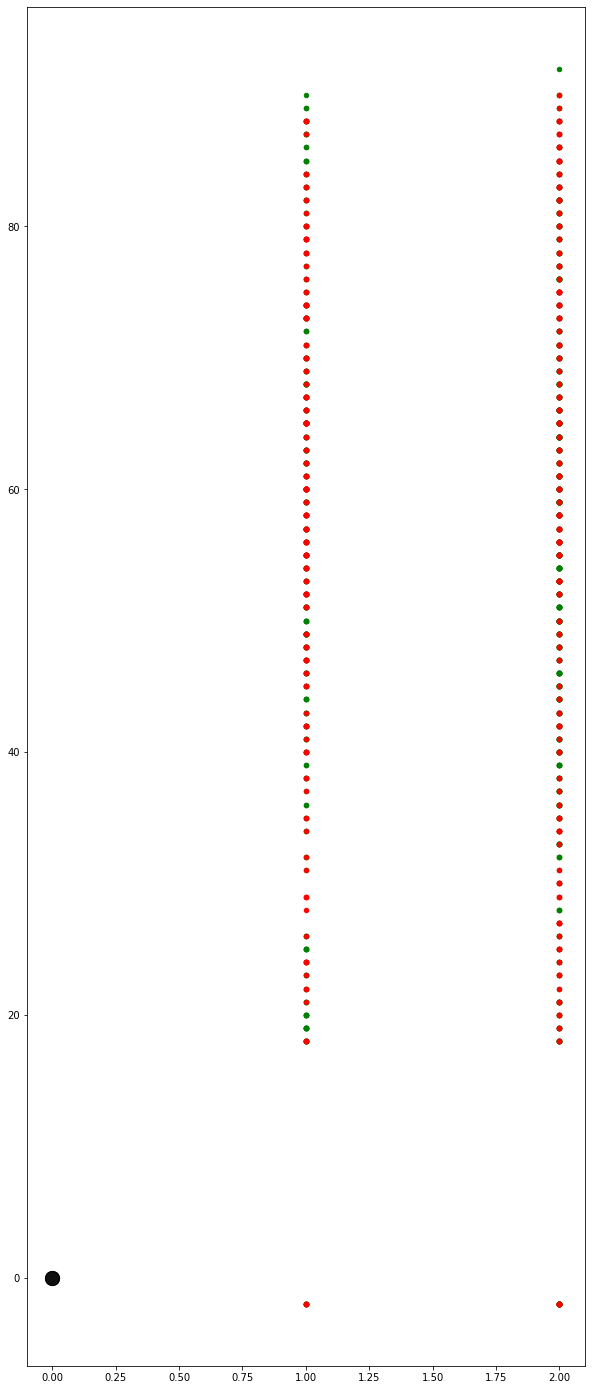

In [145]:
import matplotlib.pyplot as plt
i = 0
make_plot(genderage_pair,km_type.pred(arr_location_type),plt,i)
i += 1

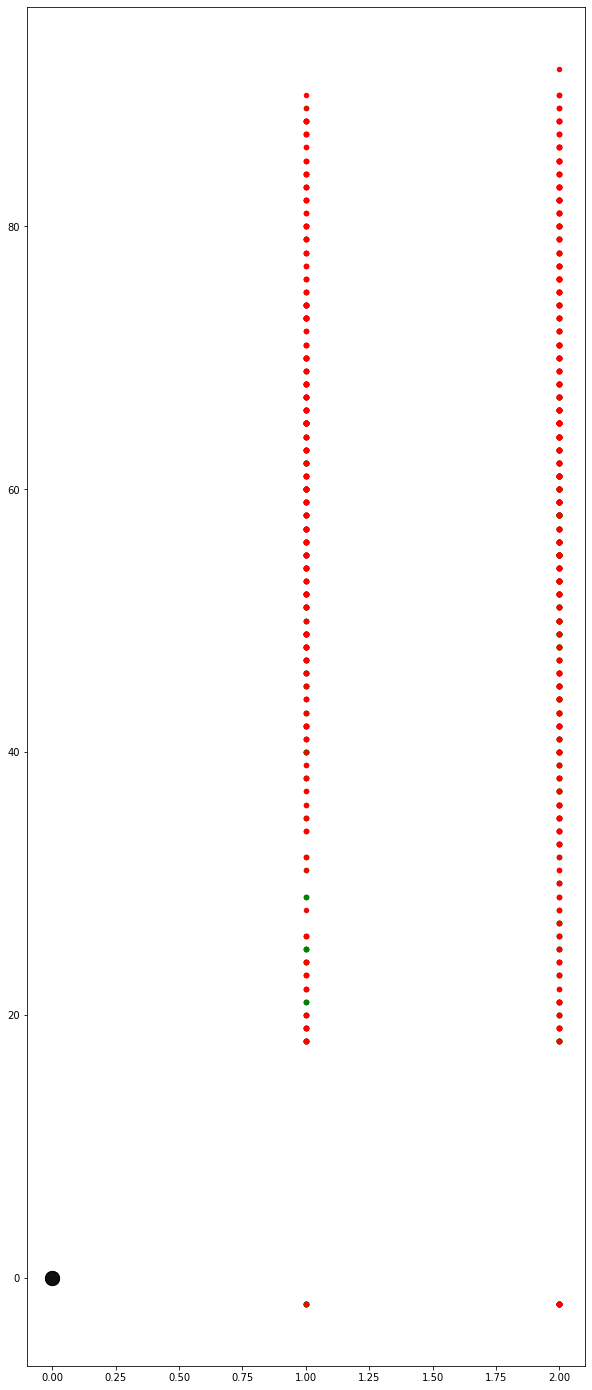

In [146]:
import matplotlib.pyplot as plt
make_plot(genderage_pair,km_duration.pred(arr_duration),plt,i)

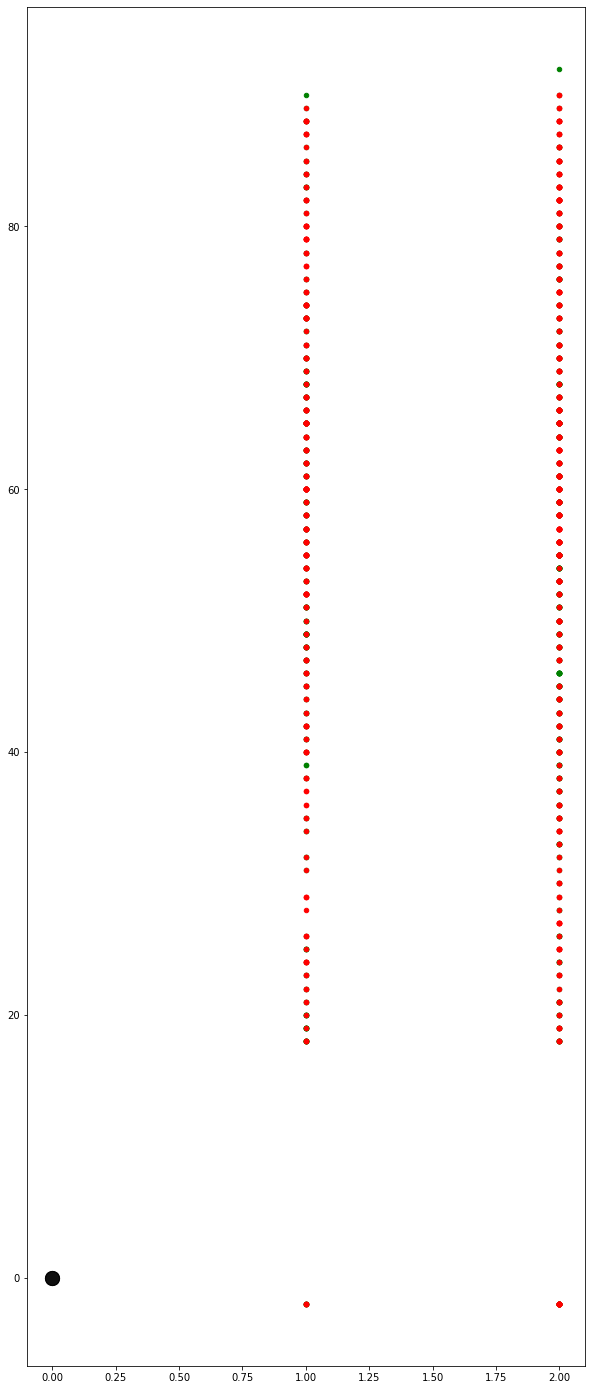

In [147]:
i += 1
import matplotlib.pyplot as plt
make_plot(genderage_pair,km_freq.pred(arr_freq),plt,i)

In [161]:
from sklearn.cluster import SpectralClustering

clustering_freq = SpectralClustering(n_clusters=2,assign_labels="discretize",random_state=0).fit(arr_freq)
sum(clustering_freq.labels_)

6

In [162]:
from sklearn.cluster import SpectralClustering

clustering_type = SpectralClustering(n_clusters=2,assign_labels="discretize",random_state=0).fit(arr_location_type)
sum(clustering_type.labels_)

536

In [163]:
from sklearn.cluster import SpectralClustering

clustering_duration = SpectralClustering(n_clusters=2,assign_labels="discretize",random_state=0).fit(arr_duration)
sum(clustering_duration.labels_)

/usr/local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:99: RuntimeWarning: invalid value encountered in true_divide
  vectors = vectors / np.sqrt((vectors ** 2).sum(axis=1))[:, np.newaxis]


0

In [164]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(arr_location_type)
all_predictions = model.predict(arr_location_type)
print(all_predictions)

[1 0 0 ... 1 1 2]


In [173]:
location_types = ['Arts and culture', 'Car journey', 'Home', 'Other', 'Public spaces', 'Transport', 'Retail and hospitality', 'Study', 'Sport and recreation', 'Work']

In [185]:
pred0 = []
pred1 = []
pred2 = []
genderage0 = []
genderage1 = []
genderage2 = []
for i,pre in enumerate(all_predictions):
    if pre == 0:
        l = arr_location_type[i]
        lr0 = [lt for j,lt in enumerate(location_types) if l[j] == 1]
        if lr0 not in pred0:
            pred0.append(lr0)
        if genderage_pair[i] not in genderage0:
            genderage0.append(genderage_pair[i])
        
    elif pre == 1:
        l = arr_location_type[i]
        lr1 = [lt for j,lt in enumerate(location_types) if l[j] == 1]
        if lr1 not in pred1:
            pred1.append(lr1)
        if genderage_pair[i] not in genderage1:
            genderage1.append(genderage_pair[i])
    else:
        l = arr_location_type[i]
        lr2 = [lt for j,lt in enumerate(location_types) if l[j] == 1]
        if lr2 not in pred2:
            pred2.append(lr2)
        if genderage_pair[i] not in genderage2:
            genderage2.append(genderage_pair[i])

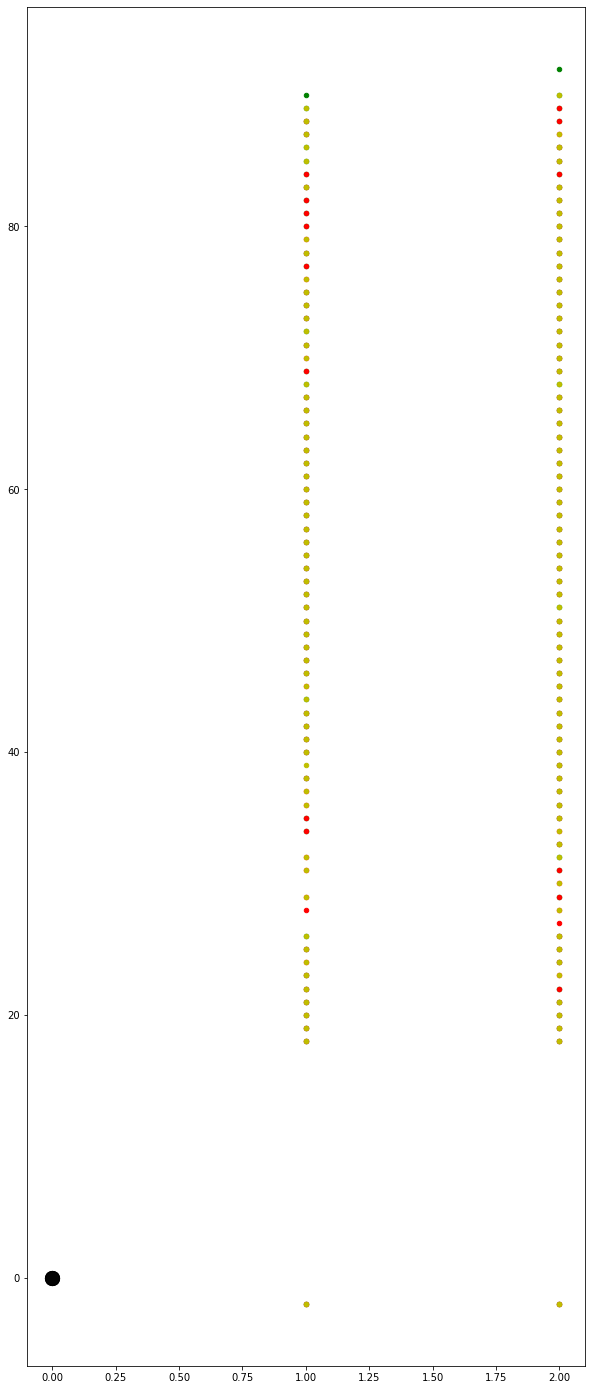

In [193]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,25))
plt = plot_cluster(np.asarray(genderage0), init_vec_type,'g',plt)
plt = plot_cluster(np.asarray(genderage1), init_vec_type,'r',plt)
plt = plot_cluster(np.asarray(genderage2), init_vec_type,'y',plt)
plt.savefig('test0.png')
plt.show()

<Figure size 432x288 with 0 Axes>

In [181]:
print(pred0)
print(pred1)
print(pred2)

[['Home', 'Transport', 'Retail and hospitality'], ['Car journey', 'Home', 'Retail and hospitality', 'Sport and recreation'], ['Home', 'Public spaces', 'Retail and hospitality'], ['Arts and culture', 'Home', 'Retail and hospitality', 'Study', 'Work'], ['Home', 'Retail and hospitality'], ['Home', 'Transport', 'Retail and hospitality', 'Sport and recreation'], ['Arts and culture', 'Home', 'Public spaces', 'Transport', 'Retail and hospitality'], ['Home', 'Transport', 'Retail and hospitality', 'Study', 'Sport and recreation'], ['Home', 'Transport', 'Retail and hospitality', 'Work'], ['Home', 'Retail and hospitality', 'Sport and recreation'], ['Car journey', 'Home', 'Transport', 'Retail and hospitality', 'Study', 'Sport and recreation'], ['Home', 'Transport', 'Retail and hospitality', 'Study'], ['Home', 'Retail and hospitality', 'Study'], ['Arts and culture', 'Home', 'Transport', 'Retail and hospitality'], ['Home', 'Public spaces', 'Transport', 'Retail and hospitality'], ['Car journey', 'Hom

In [76]:
from sklearn.datasets.samples_generator import make_blobs
x, y = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
